In [3]:
%matplotlib inline
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [43]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline

# Create a class to create pandas dataframe from SQL queries

In [64]:
#Read data from JDBC server
class DB:
    def __init__(self):
        self.tables = None
        self.df = None
        self.point = None
        self.POSTGRES_HOST = "codd03.research.northwestern.edu"
        self.POSTGRES_PORT = 5432
        self.POSTGRES_DBNAME = 'cpdb'
        self.POSTGRES_USERNAME = 'cpdb_student'
        self.POSTGRES_PASSWORD = 'DataSci4Lyfe'
        self.postgres_str = ('postgresql://{username}:{password}@{host}:{port}/{dbname}'.format(username=self.POSTGRES_USERNAME,
                                                                                           password=self.POSTGRES_PASSWORD,
                                                                                           host=self.POSTGRES_HOST,
                                                                                           port=self.POSTGRES_PORT,
                                                                                           dbname=self.POSTGRES_DBNAME))
        self.engine = create_engine(self.postgres_str)

    def query(self, queryCommand):
            self.point = self.engine.execute(queryCommand)
            self.df = None
            try: self.df = pd.DataFrame([*self.point.mappings()])
            except Exception as msg:
                if msg == 'This result object does not return rows. It has been closed automatically.':pass
            return self.df

    def get_tables_from_commands(self, commands=None):
        self.tables = {}
        for command in commands:
            try:
                df = self.query(command)
                if df is not None:
                    self.tables[f't{len(self.tables.keys())}'] = {'frame': df, 'sql': command}
            except:
                pass
        return self.tables



In [65]:
# test it out

def test():
    obj_test = DB()
    t = obj_test.get_tables_from_commands

    query1 = '''
    DROP TABLE if exists area_ids;
    CREATE TEMP TABLE area_ids AS
        ( SELECT id, name FROM data_area
          WHERE area_type='police-districts');
    SELECT * FROM area_ids;

    -- Determining civilian population of each PD
    DROP TABLE IF EXISTS popul_by_pd;
    CREATE TEMP TABLE popul_by_pd AS
        ( SELECT area_id, SUM("count") population FROM data_racepopulation
          WHERE area_id IN (SELECT id FROM area_ids)
          group by area_id);
    select * from popul_by_pd;
    '''

    commands = query1.split(';')
    tables = t(commands)
    if len(tables.keys()) == 2: print("Passed!")
    else: print("An error occurred")

    del obj_test

test()

Passed!


<br>

### Preprocessing helpers

In [66]:
# keep columns which have more than 85% missing values
def remove_missing(df):
    columns = list(df1.columns)
    print(f"Originallly {len(columns)} columns")
    missing = pd.DataFrame(df1.isnull().sum())
    missing.reset_index(inplace=True)
    missing = missing.rename(columns = {'index':'columns', 0: 'null count'})
    missing["null count"] = missing["null count"].apply(lambda x: x*100/len(df1))
    remaining_columns = missing[missing["null count"] < 85.0]["columns"]
    print(f"Dropped to {len(remaining_columns)} columns")
    print(list(remaining_columns))
    return list(remaining_columns)

In [67]:
scalerST = preprocessing.StandardScaler()
scalerRB = preprocessing.RobustScaler()
scalers = [('std', scalerST), ('rb', scalerRB)]

### model selection helpers

In [123]:
# linear models

regrLinear = linear_model.LinearRegression()
regrRidge = linear_model.Ridge()
regrGamma = linear_model.GammaRegressor()

models = [ ('lreg', regrLinear), ('rreg', regrRidge), ('greg', regrGamma)]


<br>

# Get all required tables

In [69]:
def table_from_file(filename):
    obj = DB()
    t = obj.get_tables_from_commands
    with open(filename, 'r') as f:
        sqlFile = f.read()
    commands_raw = sqlFile.split(';')
    commands = []
    for command in commands_raw:
        q = f'''
        {command}
        '''
        commands.append(q)
    tables = t(commands)
    total = len(tables.keys())
    print(total, "tables received")
    del obj
    return (total, tables)

# console1.sql

In [70]:
filename = 'console1.sql'
total, tables = table_from_file(filename)

3 tables received


### Data visualization

In [71]:
df0 = tables['t0']['frame']
q0 = ' '.join(tables['t0']['sql'].split('\n'))
print(q0)
df0.to_csv('tables\\df0.csv')

          select * from trr_count_by_year_side         


In [72]:
df1 = tables['t1']['frame']
q1 = ' '.join(tables['t1']['sql'].split('\n'))
print(q1)
df1.to_csv('tables\\df1.csv')

          select * from trr_count_by_year         


In [76]:
df2 = tables['t2']['frame']
q2 = ' '.join(tables['t2']['sql'].split('\n'))
print(q2)
df2.to_csv('tables\\df2.csv')

          select * from trr_count_by_year_beats         


In [73]:
df0 = pd.read_csv("tables\\df0.csv").sort_values(by="years")

In [74]:
df1 = pd.read_csv("tables\\df1.csv").sort_values(by="years")

In [77]:
df2 = pd.read_csv("tables\\df2.csv").sort_values(by="years")

**What is TRR?**
TRR is the abbreviation for *Tactical Response Reports*. Usually an event has one complaint with a unique id (CRID) linked to it. But in cases when an event has one or more use of force reports linked to it, it comes under TRR data.

Let's check out the trr counts from each year. First we'll look at overall trr count yearly, and then we will visualize the trr count by year distinguished by north and south sides.

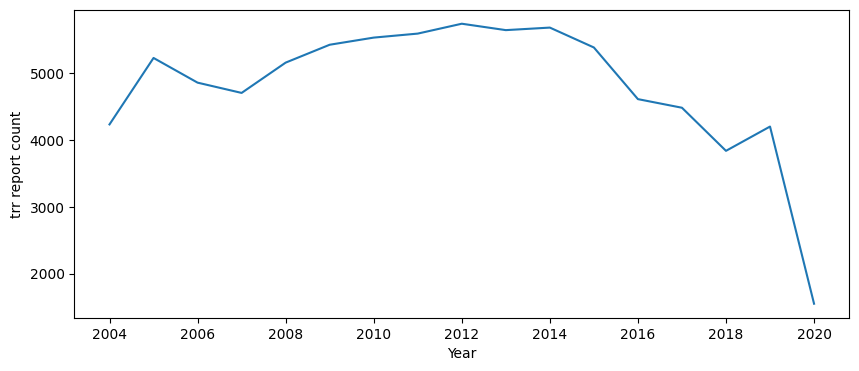

In [78]:
count = list(df1["count"])
years = list(df1["years"])

plt.figure(figsize=(10,4))
plt.plot(years, count)
plt.xlabel("Year")
plt.ylabel("trr report count")
# plt.xticks(np.arange(len(years)), list(years))
plt.show()

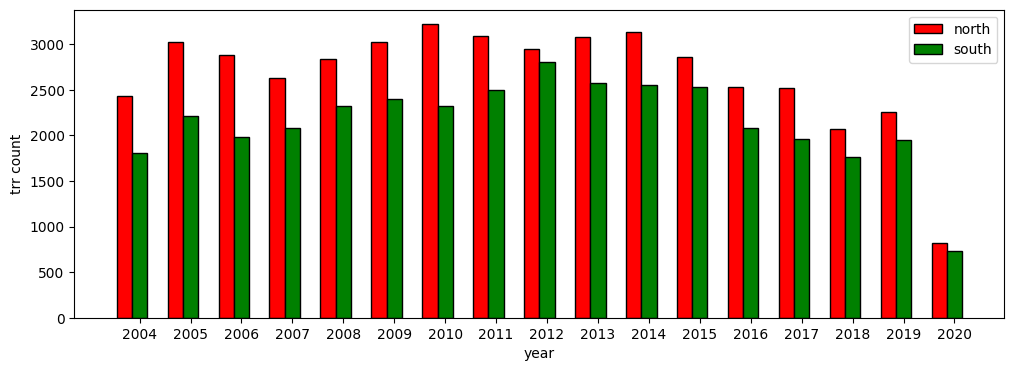

In [79]:
barwidth = 0.3

years = df0[df0["side"]=='north']["years"] # same for south
countNorth = df0[df0["side"]=='north']["count"]
countSouth = df0[df0["side"]=='south']["count"]

r1 = np.arange(len(countNorth))
r2 = [x + barwidth for x in r1]

fig = plt.subplots(figsize=(12, 4))
plt.bar(r1, countNorth, width=barwidth, color='r', edgecolor="black", label="north")
plt.bar(r2, countSouth, width=barwidth, color='g', edgecolor="black", label="south")
plt.xlabel("year")
plt.ylabel("trr count")
plt.xticks([r + barwidth for r in range(len(countNorth))], years)
plt.legend()
plt.show()


### Observation:
It is interesting to note that in all cases multiple cases of complaint reports related to a single event comes usually from the north side. Overall, 2020 has far fewer trr reports. These could be because the data for 2020 is more recent and possibly lacking.

### Question

Can we use this information to create a reliable model that can predict the trr count per year? We are going to use df2 for this part, which contains all the beat names and is categorized according to trr count per year per beat.

In [99]:
df2.head(3).drop(columns=['Unnamed: 0'])

,beat,count,years
0,1923,7,2004
2957,1922,3,2004
2966,211,7,2004


In [100]:
y = np.array(df2["count"])
X = np.array(df2[['beat', 'years']])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(len(X_train), '\n', len(X_test))

3540 
 885


array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 ])

Checking out a very simple model first! We are only using standard scaler followed by linear regression

In [152]:
X_tf = scalerST.fit_transform(X_train)
regrLinear.fit(X_tf, y_train)
metrics.r2_score(y_test, regrLinear.predict(X_test))


-150565.71533747594

This simple model performs VERY poorly. Can we improve?

In [154]:
pipelines = []
scaling_union = ('scaler', pipeline.FeatureUnion(scalers))
params = [{'lreg__positive': [True, False]},
          {'rreg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'rreg__positive': [True, False]},
          {'greg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'greg__warm_start': [True, False]}]

for i in range(len(models)):
    print(models[i][1])
    reg = pipeline.Pipeline([scaling_union, models[i]])
    grids = model_selection.GridSearchCV(reg, param_grid=params[i], cv=5)
    grids.fit(X_train, y_train)
    best_estimator = grids.best_estimator_
    pipelines.append(best_estimator)
    best_estimator.fit(X_train, y_train)
    score = metrics.r2_score(y_test, best_estimator.predict(X_test))
    print("Best r2 score: ", score)
    print("Best hyperparameters for this regressor: ", grids.best_params_)
    print()

LinearRegression()
Best r2 score:  0.026736105500523077
Best hyperparameters for this regressor:  {'lreg__positive': False}

Ridge()
Best r2 score:  0.026492116501215968
Best hyperparameters for this regressor:  {'rreg__alpha': 1, 'rreg__positive': False}

GammaRegressor()
Best r2 score:  0.02170125393715261
Best hyperparameters for this regressor:  {'greg__alpha': 0.05, 'greg__warm_start': True}



A little better than what we had before. We should use the first the linear regression model.

<br>

### Question

How can we improve now?

Let us use a bit more information, such as the officer history of the officers involved in the trr incidents.